# Simulation Based Calibration Applied To 8 Schools

In [1]:
import pystan
import json
from model import Model, save_model, load_model
from normal import Normal
from pystan.misc import read_rdump
from scipy.stats import t as student_t
from scipy.special import gamma
from scipy.special import gammaln
from autograd.numpy.linalg import slogdet
import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import grad
from autograd.extend import primitive, defvjp
from scipy.stats import multivariate_normal
#import numpy as np
import copy
import matplotlib.pyplot as plt
from random import randrange
from random import randint
from autograd.numpy import log, exp, sqrt
import random
import time
import math
import pandas as pd
from math import sqrt
from IPython.core import display as ICD
from scipy.stats import chisquare
from matplotlib.pyplot import figure


random.seed(1234)
random.seed(2345)
#random.seed(3456)

In [2]:
model = "eight_schools"
data = "json"
if data is not None:
    if data == "json":
        data_dir = "./models/{0}/{0}.json".format(model)
        with open(data_dir) as json_file:
            data = json.loads(json_file.read())
    elif data == "rdump":
        data = read_rdump("./models/{0}/{0}.data.R".format(model))

print("\n-----------------")
print("----- TESTING PYSTAN -----")
print("-----------------")
sm = pystan.StanModel(file="./models/{0}/{0}.stan".format(model))


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb253e9d09985ea45ecc69d874e246ca NOW.



-----------------
----- TESTING PYSTAN -----
-----------------


## SETTINGS

In [3]:
APPLY_THINNING = False

## SBC WITH THINNING

In [4]:
if APPLY_THINNING:
    nb_of_tests = 500
    total_ranks = []

    fit_test = sm.sampling(data=data, algorithm="NUTS", iter=10, chains=1)
    number_of_params_to_evaluate = len([s for s in list(fit_test.extract()) if "_sim" in s])

    ranks_per_param = [[] for x in range(number_of_params_to_evaluate)]

    for t in range(nb_of_tests):

        Low_N_Eff = 999 # On instancie ça a cette valeur pour au debuté ne pas trop modifier L_prime
        L = 1000 # donc M apres   sachant que COMME POUR L_PRIME c'est nb_iter * nb_mc
        N = 200
        L_prime = 1000
        nb_MC = 10
        nb_iter = int(L_prime / nb_MC)

        while Low_N_Eff < L:

            L_prime = L_prime * int(L/Low_N_Eff)

            nb_iter = int(L_prime / nb_MC)

            fit = sm.sampling(data=data, algorithm="NUTS", iter=nb_iter, chains=nb_MC)

            nb_of_interesting_neff = 0
            for i in fit.par_dims[:len(priors_to_evaluate)]:
                if len(i) == 0 :
                    nb_of_interesting_neff += 1
                else:
                    nb_of_interesting_neff += i[0]

            n_effs = fit.summary()["summary"][:nb_of_interesting_neff,fit.summary()['summary_colnames'].index("n_eff")]

            Low_N_Eff = np.min(n_effs)

        priors_simulated = [s for s in list(fit.extract()) if "_sim" in s]
        priors_to_evaluate = [r[:r.index("_sim")] for r in priors_simulated]

        for p in range(len(priors_simulated)):
            # On prend l'actuel prior simulé et on trouve son homologue non simulé
            current_param = priors_simulated[p][:priors_simulated[p].index("_sim")] 
            # Pour pouvoir en extraire les données
            sampled_data = np.array(list(fit.extract(current_param).values()))[0][:]
            unthinned_samples = sampled_data.shape[0]
            simulated_data = np.array(list(fit.extract(priors_simulated[p]).values()))[0][:]
            if len(sampled_data.shape) > 1 :
                sampled_data = sampled_data[np.linspace(0, unthinned_samples-1, L, dtype=int),:]
                simulated_data = simulated_data[np.linspace(0, unthinned_samples-1, L, dtype=int),:]
            else:
                sampled_data = sampled_data[np.linspace(0, unthinned_samples-1, L, dtype=int)]
                simulated_data = simulated_data[np.linspace(0, unthinned_samples-1, L, dtype=int)]
            param_ranks = sum(sampled_data < simulated_data)
            ranks_per_param[p].append(param_ranks)       

### SBC WITHOUT THINNING

In [5]:
if APPLY_THINNING==False:
    nb_of_tests = 1000
    total_ranks = []

    fit_test = sm.sampling(data=data, algorithm="NUTS", iter=10, chains=1)
    number_of_params_to_evaluate = len([s for s in list(fit_test.extract()) if "_sim" in s])

    ranks_per_param = [[] for x in range(number_of_params_to_evaluate)]

    for t in range(nb_of_tests):

        fit = sm.sampling(data=data, algorithm="NUTS", iter=1000, chains=10)

        priors_simulated = [s for s in list(fit.extract()) if "_sim" in s]
        priors_to_evaluate = [r[:r.index("_sim")] for r in priors_simulated]

        for p in range(len(priors_simulated)):
            # On prend l'actuel prior simulé et on trouve son homologue non simulé
            current_param = priors_simulated[p][:priors_simulated[p].index("_sim")] 
            # Pour pouvoir en extraire les données
            sampled_data = np.array(list(fit.extract(current_param).values()))[0][:]
            simulated_data = np.array(list(fit.extract(priors_simulated[p]).values()))[0][:]
            param_ranks = sum(sampled_data < simulated_data)
            ranks_per_param[p].append(param_ranks)

### TEST UNIFORMITY

In [6]:
if APPLY_THINNING==False:
    ## Enfait dans l'exemple de Stan ils partent du principe que M (draws) == Nb de tests alors que non, pas forcément !
    # IF USING MCMC 
    nb_of_chains = len(fit.stan_args)
    nb_of_draws_per_chain = fit.stan_args[0]["iter"]/2
    nb_draws = int(nb_of_draws_per_chain*nb_of_chains)
    M = nb_draws # Number of samples generated by each test, we'll have to devide thus the nb of rank by it.

if APPLY_THINNING:
    ### AFTER THINNING
    M = np.max(ranks_per_param[0]) # Number of samples generated by each test, we'll have to devide thus the nb of rank by it.

J = 10 # nb of element per bin
e_j = int((nb_of_tests+1)/J)  # Attention ce n'est pas M !!!
   
params_pvalues = [[] for x in range(number_of_params_to_evaluate)]  # param x D 

for p in range(number_of_params_to_evaluate):
    param_pvalues = []
    if np.array(ranks_per_param[p][0]).size != 1:  #SI ON A PLUSIEURS DIMENSIONS ALORS
        for d in range(np.array(ranks_per_param[p][0]).size):
            b_j = np.zeros(J)
            for t in range(nb_of_tests):
                r = np.array(ranks_per_param[p])[t,d]
                resulting_bin_j = int(r/((M+1)/J))
                b_j[resulting_bin_j] +=1
                
            _, pvalue = chisquare(f_obs=b_j, f_exp=e_j)
            param_pvalues.append(pvalue)       
    else: # SI ON A QU'UNE DIMENSIONS ALORS 
        b_j = np.zeros(J)
        for t in range(nb_of_tests):
            r = ranks_per_param[p][t]
            resulting_bin_j = int(r/((M+1)/J))
            b_j[resulting_bin_j] +=1
            
        _, pvalue = chisquare(f_obs=b_j, f_exp=e_j)
        param_pvalues.append(pvalue)
    params_pvalues[p] = param_pvalues

In [7]:
b_j

array([102., 105., 104., 101.,  85.,  99.,  90.,  99., 114., 101.])

In [8]:
e_j

100

In [9]:
for p in range(number_of_params_to_evaluate):
    print(priors_to_evaluate[p], "  p:", np.mean(params_pvalues[p]))

mu   p: 0.02126165949932571
tau   p: 0.6433663247783736
theta   p: 0.5777998490600957


### QUICK PLOTS OF THE PARAMS UNIFORMITY

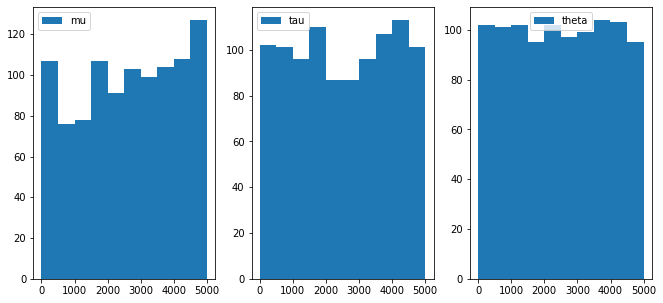

In [10]:
plt.figure(figsize=(15,5))
# ON VEUT UNE LIGNE ET 4 COLONNES DONC FAUT UTILISER plt.subplot(141) pour le 1er element puis plt.subplot(142) pour le 
#deuxieme etc, donc là on va juste créer le chiffre 140 puis on va ajouter le numéro pour faire ça bien.

number=140

for p in range(number_of_params_to_evaluate):
    plt.subplot(number+p+1)
    if len(np.array(ranks_per_param[p]).shape) == 1 :
        plt.hist(np.array(ranks_per_param[p]), label=priors_to_evaluate[p])
    else:
        plt.hist(np.array(ranks_per_param[p])[:,0], label=priors_to_evaluate[p])       
    plt.legend(loc='best')

plt.show()

### N_Eff AND THINING

In [11]:
nb_of_interesting_neff = 0
for i in fit.par_dims[:len(priors_to_evaluate)]:
    if len(i) == 0 :
        nb_of_interesting_neff += 1
    else:
        nb_of_interesting_neff += i[0]
        
fit.summary()["summary"][:nb_of_interesting_neff,fit.summary()['summary_colnames'].index("n_eff")]

array([ 307.02665101,  749.6401154 , 2636.63700453, 1847.24313886,
       3618.44375759, 1516.70978161, 2622.49579876, 1640.09281711,
       2685.86209041, 2818.05815972])

In [12]:
n_effs = fit.summary()["summary"][:nb_of_interesting_neff,fit.summary()['summary_colnames'].index("n_eff")]

In [13]:
if any(n_effs < nb_of_tests):
    print("MORE TESTS DRAWS ARE NEEDED")

MORE TESTS DRAWS ARE NEEDED


## $\chi^2$ Evaluation between simulated and infered parameters (1=perfect correlation)



- nl = number of simulated likelihood
- ns = number of samples (mcmc steps $\times$ nb of chains) per simulated likelihood

### CENTERED 8 SCHOOLS
| Left | 500ns, 200nl | 5000ns, 200nl | 500ns, 1000nl | 5000ns, 1000nl |
|:---|:---:|---:|---:|---:|
| $\mu$ | 0.53 | 0.35 | 0.012 | 0.31 |
| $\tau$ | 0.21 | 0.10 | 0.0007 | 0.012 |
| $\theta$ | 0.45 | 0.48 | 0.55 | 0.73 |

### NON-CENTERED 8 SCHOOLS
| Left | 500ns, 200nl | 5000ns, 200nl | 500ns, 1000nl | 5000ns, 1000nl |
|:---|:---:|---:|---:|---:|
| $\mu$ | 0.97 | 0.18 | 0.70 | 0.02 |
| $\tau$ | 0.90 | 0.72 | 0.52 | 0.64 |
| $\theta$ | 0.39 | 0.49 | 0.56 | 0.58 |